<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/main/notebooks/3rd_week_note_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
from pathlib import Path

import torch
import torchaudio


In [2]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
# !는 주피터에서 터미널 명령어를 사용할때 붙임
# python이 아닌 OS (Linux)에 명령을 내리고 싶을 때 실행


--2024-03-18 04:56:50--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|74.125.200.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  23.0MB/s    in 16s     

2024-03-18 04:57:08 (20.7 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]



In [3]:
# 압축 풀기
!tar -xf nsynth-test.jsonwav.tar.gz

In [4]:
meta = json.load(open('nsynth-test/examples.json'))
len(meta)

4096

In [7]:
# 데이터셋이 어떻게 구성돼있는지 보기
list(meta.keys())[:5]

['bass_synthetic_068-049-025',
 'keyboard_electronic_001-021-127',
 'guitar_acoustic_010-066-100',
 'reed_acoustic_037-068-127',
 'flute_acoustic_002-077-100']

In [8]:
meta['bass_synthetic_068-049-025']

{'qualities': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'pitch': 49,
 'note': 217499,
 'instrument_source_str': 'synthetic',
 'velocity': 25,
 'instrument_str': 'bass_synthetic_068',
 'instrument': 656,
 'sample_rate': 16000,
 'qualities_str': ['dark'],
 'instrument_source': 2,
 'note_str': 'bass_synthetic_068-049-025',
 'instrument_family': 0,
 'instrument_family_str': 'bass'}

In [9]:
# 메타의 키 이름이 파일 이름
fn = 'bass_synthetic_068-049-025' + '.wav'
audio_dir = Path('/content/nsynth-test/audio')

# audio directory 가 존재하는지 확인
audio_dir.exists()

True

In [11]:
audio_fn = audio_dir / fn
audio_fn, audio_fn.exists()

(PosixPath('/content/nsynth-test/audio/bass_synthetic_068-049-025.wav'), True)

In [12]:
import IPython.display as ipd

y, sr = torchaudio.load(audio_fn) # torchaudio.laod returns (wavesamples, sampling_rate)
ipd.Audio(y, rate=sr)

In [15]:
# check metadata and file consistency

fns = sorted(list(meta.keys()))
fns[:10]

['bass_electronic_018-022-100',
 'bass_electronic_018-023-025',
 'bass_electronic_018-023-075',
 'bass_electronic_018-023-127',
 'bass_electronic_018-024-025',
 'bass_electronic_018-024-100',
 'bass_electronic_018-026-025',
 'bass_electronic_018-026-075',
 'bass_electronic_018-026-127',
 'bass_electronic_018-027-075']

In [22]:
# !mv nsynth-test/audio/bass_electronic_018-026-127.wav nsynth-test/
!mv nsynth-test/bass_electronic_018-026-127.wav nsynth-test/audio/

In [23]:
# for every filename, check the file exists
for fn in fns:
  does_exist = (audio_dir / fn).with_suffix('.wav').exists()
  assert does_exist, f"{fn} does not exist"

In [25]:
# Convert audio to spectrogram
y.shape # [1, T] . SR: 16000, Duration: 4

torch.Size([1, 64000])

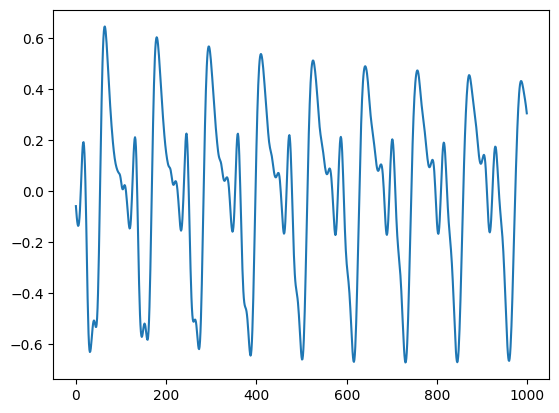

In [27]:
import matplotlib.pyplot as plt
plt.plot(y[0, 1000:2000]) # If you select single value in sepcific dimension, that dimension disappears

In [44]:
# Convert waveform to spectrogram using torchaudio

spec_converter = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=512)

spec = spec_converter(y)

In [45]:
spec.shape # num channel of input x num frequency bin x num time bin
# num frequency bin = n_fft // 2 + 1


torch.Size([1, 513, 126])

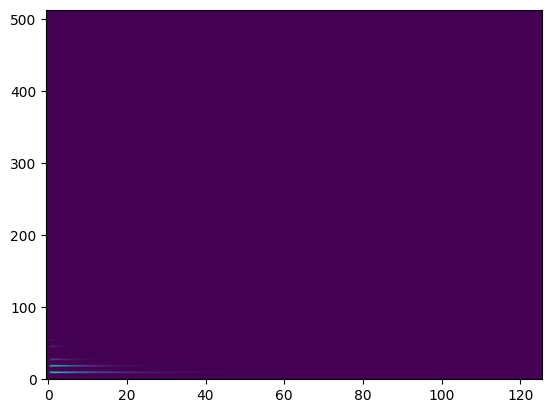

In [46]:
plt.imshow(spec[0], aspect='auto', origin='lower')

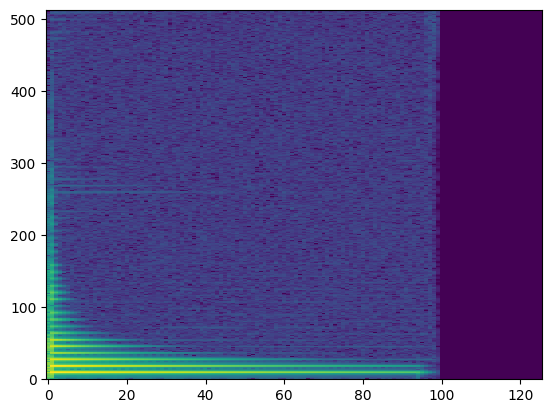

In [47]:
db_converter = torchaudio.transforms.AmplitudeToDB()
db_spec = db_converter(spec)
plt.imshow(db_spec[0], aspect='auto', origin='lower', interpolation='none')

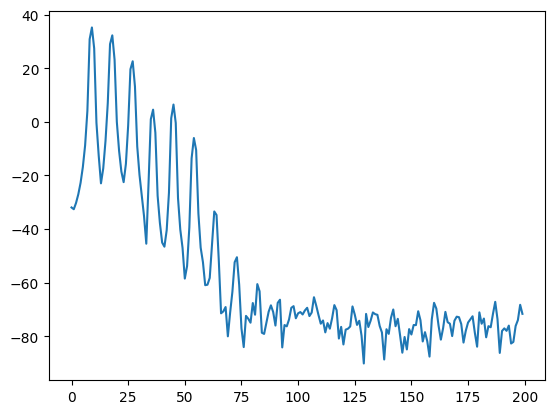

In [50]:
time_idx = 10
spectrum = db_spec[0, :200, time_idx] # select 0th channel, all frequency, time-idx-th time frame
plt.plot(spectrum)

torch.Size([513, 80])


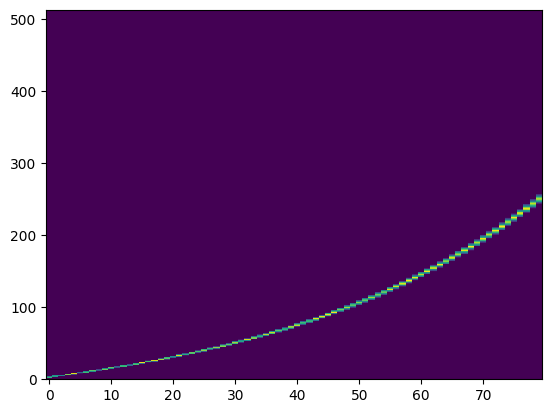

In [92]:
# compress frequency scale to log scale
mel_scale = torchaudio.transforms.MelScale(n_mels=80, sample_rate=16000, f_min=20, f_max=4000, n_stft=513)

print(mel_scale.fb.shape)
plt.imshow(mel_scale.fb, aspect='auto', origin='lower', interpolation='none')

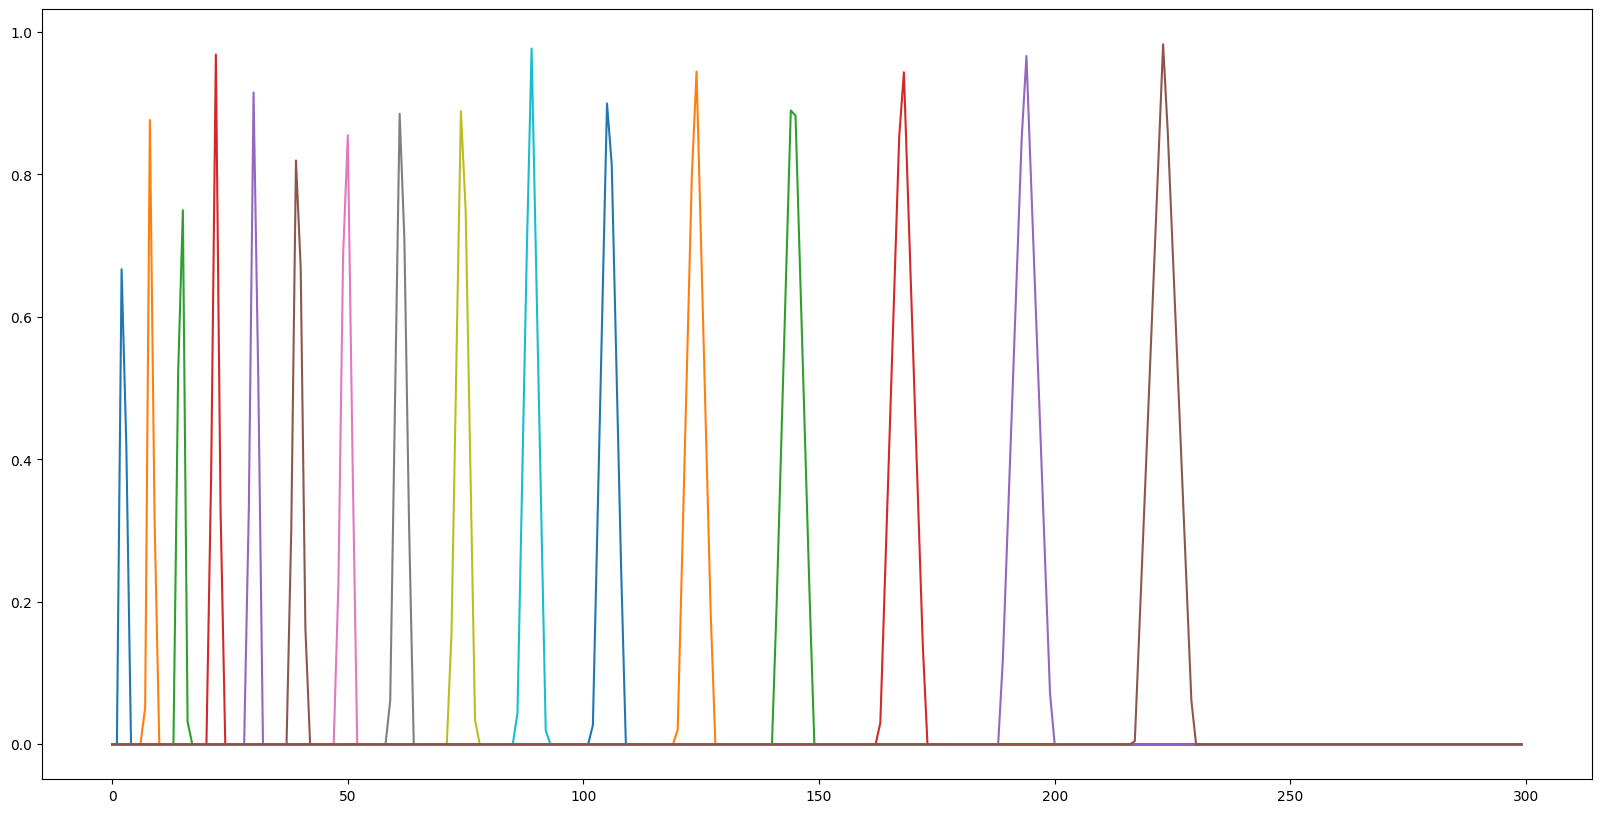

In [93]:
plt.figure(figsize=(20, 10))

for i in range(0, mel_scale.fb.shape[1], 5):
  plt.plot(mel_scale.fb[:300, i])



In [94]:
mel_spec = torch.mm(mel_scale.fb.T, spec[0])
spec.shape, mel_scale.fb.shape, mel_spec.shape

(torch.Size([1, 513, 126]), torch.Size([513, 80]), torch.Size([80, 126]))

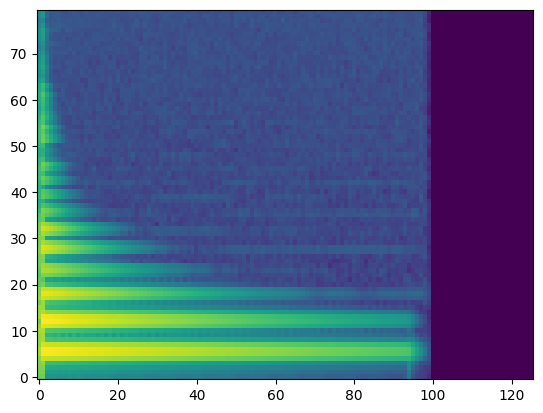

In [96]:
mel_db_spec = db_converter(mel_spec)

plt.imshow(mel_db_spec, origin='lower', aspect='auto', interpolation='none')

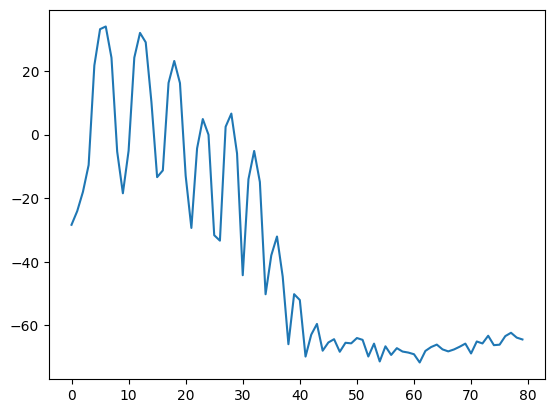

In [98]:
time_idx = 10
spectrum = mel_db_spec[:, time_idx] # select 0th channel, all frequency, time-idx-th time frame
plt.plot(spectrum)

In [107]:
mel_converter = torchaudio.transforms.MelSpectrogram(n_fft=1024,
                                                     hop_length=512,
                                                     f_min=20,
                                                     f_max=4000,
                                                     n_mels=80)

class MelDbConverter(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mel_conv = torchaudio.transforms.MelSpectrogram(n_fft=1024,
                                                     hop_length=512,
                                                     f_min=20,
                                                     f_max=4000,
                                                     n_mels=80)
    self.db_conv = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    return self.db_conv(self.mel_conv(x))

mel_db_conv = MelDbConverter()
mel_db_conv(y).shape

torch.Size([1, 80, 126])

## Make sine wave

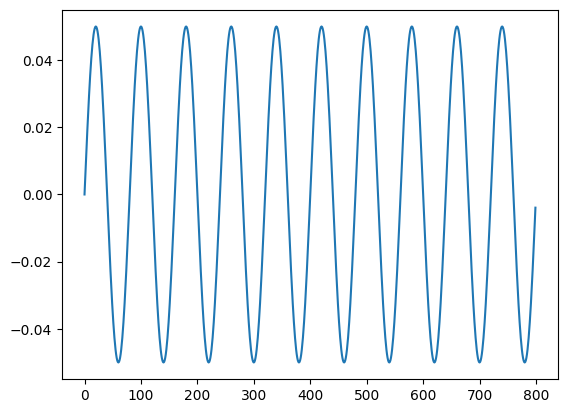

In [87]:
from math import pi

freq = 200
sampling_rate = 16000
dur=4
def make_sine_wave(freq, sampling_rate, dur=4):
  total_duration_in_sample = sampling_rate * dur
  time_in_sec = torch.arange(total_duration_in_sample) / sampling_rate
  time_in_sec

  # 1 period of angle = 2 * pi
  # 220 period of angle = 2 * pi * 220 / sec

  angular_speed =  2 * pi * freq  # angle / sec

  accumulated_angle = time_in_sec * angular_speed  # 거리 = 속도 x 시간
  sine_wave = torch.sin(accumulated_angle) / 20
  return sine_wave

sine_wave = make_sine_wave(freq, sampling_rate)
plt.plot(sine_wave[:800])

# 800 이 0.05초에 해당한다면
# 800 샘플 동안 11번 진동하면 우리가 듣는 주파수: 11 / 0.05 = 11 * 20 = 220
# 800 이 0.1초에 해당한다면 ~= sampling rate = 8000
# 11 / 0.1 = 11 * 10 = 110

In [88]:
two_waves = make_sine_wave(freq, sampling_rate) +make_sine_wave(freq*1.5, sampling_rate) + make_sine_wave(freq * 2, sampling_rate)
ipd.Audio(two_waves, rate=16000, normalize=False)

In [79]:
ipd.Audio(sine_wave, rate=9000, normalize=False)

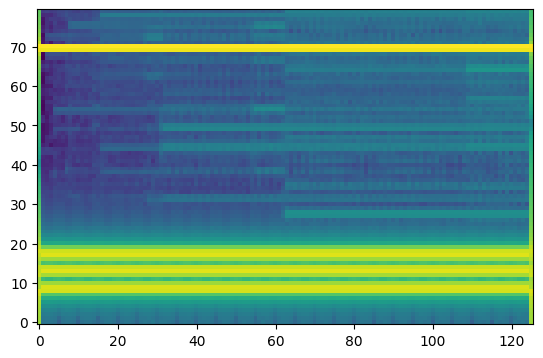

In [111]:
two_waves += make_sine_wave(3000, sampling_rate)

plt.imshow(mel_db_conv(two_waves), origin='lower')

In [114]:
# fns
audio_fns = []
for fn in fns:
  audio_fn = (audio_dir / fn).with_suffix('.wav')
  assert audio_fn.exists()
  audio_fns.append(audio_fn)
audio_fns = [(audio_dir / fn).with_suffix('.wav') for fn in fns]

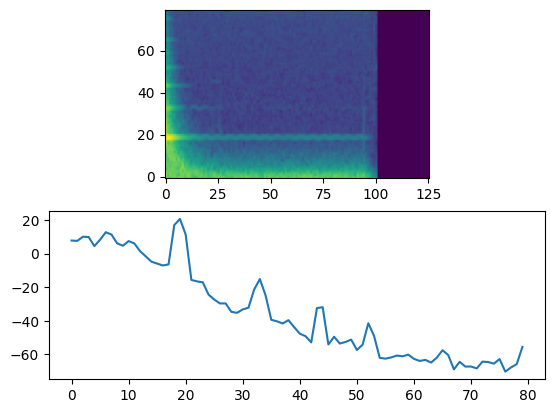

In [123]:
sample_idx = 600
audio_fn = audio_fns[sample_idx]

y, sr = torchaudio.load(audio_fn)

ipd.display(ipd.Audio(y, rate=sr, normalize=False))
mel_spec = mel_db_conv(y[0])
plt.subplot(2, 1, 1) # num_rows, num_columns, current_idx
plt.imshow(mel_spec, origin='lower')
plt.subplot(2, 1, 2)
plt.plot(mel_spec[:, 5])

In [ ]:
# 80차원 벡터를 받아서, N개의 가능한 음고 후보 각각에 대한 확률 분포를 계산


In [138]:
total_pitches = []
for value in meta.values():
  # value: dict
  pitch = value['pitch']
  total_pitches.append(pitch)
total_pitches = sorted(list(set(total_pitches)))
max(total_pitches), len(total_pitches)
# 총 120개의 pitch class가 있다고 가정

(119, 106)

In [139]:
total_pitches

[9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 110,
 113,
 115,
 116,
 118,
 119]

In [133]:
spectrum = mel_spec[:, 5] / 100
spectrum

tensor([ 0.0772,  0.0750,  0.0998,  0.0981,  0.0439,  0.0817,  0.1266,  0.1127,
         0.0603,  0.0463,  0.0738,  0.0601,  0.0143, -0.0169, -0.0485, -0.0600,
        -0.0713, -0.0649,  0.1688,  0.2058,  0.1127, -0.1575, -0.1660, -0.1713,
        -0.2443, -0.2738, -0.2970, -0.2970, -0.3471, -0.3529, -0.3326, -0.3226,
        -0.2143, -0.1518, -0.2493, -0.3945, -0.4035, -0.4164, -0.3965, -0.4379,
        -0.4770, -0.4918, -0.5289, -0.3248, -0.3194, -0.5412, -0.4951, -0.5355,
        -0.5263, -0.5123, -0.5740, -0.5422, -0.4147, -0.4897, -0.6208, -0.6255,
        -0.6182, -0.6073, -0.6115, -0.6017, -0.6267, -0.6390, -0.6328, -0.6486,
        -0.6195, -0.5754, -0.6041, -0.6895, -0.6443, -0.6726, -0.6723, -0.6836,
        -0.6432, -0.6457, -0.6553, -0.6279, -0.7028, -0.6779, -0.6582, -0.5555])

In [134]:
import torch.nn as nn

torch.manual_seed(0)
layer = nn.Linear(80, 1) # 80차원의 벡터를 받아서, 1개의 값을 예측
# 1개의 값: 하나의 음고 클래스의 확률
print(layer.weight)
layer(spectrum)

Parameter containing:
tensor([[-0.0008,  0.0600, -0.0920, -0.0823, -0.0431,  0.0300, -0.0022,  0.0886,
         -0.0099,  0.0296, -0.0338, -0.0220, -0.1068, -0.0740, -0.0461,  0.0041,
          0.0442,  0.0671, -0.0758, -0.0487,  0.0406,  0.0928, -0.0230,  0.0837,
         -0.0180,  0.0118,  0.1012, -0.1037, -0.0704, -0.0283, -0.0436,  0.0966,
         -0.0725, -0.0515, -0.0781, -0.1047, -0.0653,  0.0961,  0.0499,  0.0542,
          0.0059, -0.0573,  0.0189, -0.1044, -0.0808, -0.0576,  0.0705,  0.0656,
         -0.0496, -0.0040,  0.0715,  0.1111,  0.0444,  0.0151,  0.0750, -0.0658,
          0.0208, -0.0867, -0.0775, -0.0578,  0.0506,  0.0450, -0.0662,  0.0338,
          0.0614, -0.0141,  0.0043,  0.0259,  0.0694,  0.1074, -0.0862, -0.0410,
          0.0439,  0.0926,  0.0973,  0.0987,  0.0223, -0.0972,  0.0103, -0.0699]],
       requires_grad=True)


tensor([-0.3117], grad_fn=<ViewBackward0>)

In [137]:
torch.manual_seed(0)
layer = nn.Linear(80, 120) # 80차원의 벡터를 받아서, 120개의 값을 예측
# 1개의 값: 하나의 음고 클래스의 확률
# 120개의 값: 120개 음고 클래스 각각의 확률
# print(layer.weight)
layer(spectrum), layer(spectrum).shape

(tensor([-0.1093,  0.3431, -0.0304,  0.1671, -0.2796,  0.3220,  0.1857, -0.0263,
         -0.1833,  0.0643, -0.1575,  0.2156,  0.2179,  0.4562,  0.2870, -0.5173,
         -0.1480,  0.2878, -0.0791,  0.3986, -0.2606, -0.0794, -0.0436, -0.0205,
          0.0117, -0.3187, -0.0591,  0.0180,  0.0738, -0.0924,  0.0575,  0.5277,
          0.2153,  0.3568,  0.0391,  0.4482,  0.0063, -0.1270, -0.1194,  0.0593,
          0.4126, -0.0314, -0.1686,  0.5437,  0.4768,  0.1161, -0.3993,  0.1960,
         -0.1558, -0.0125,  0.3539, -0.0899,  0.1449,  0.1403,  0.3805, -0.4893,
          0.1350, -0.2085,  0.5307, -0.2295, -0.0819,  0.3601,  0.3083, -0.0040,
         -0.2246,  0.1612,  0.0884, -0.0796,  0.2809, -0.4854, -0.1081, -0.1112,
          0.0117,  0.5926, -0.1385, -0.4261,  0.3296,  0.3873, -0.0600, -0.0830,
          0.0808, -0.0417, -0.1641, -0.0810, -0.2994,  0.0776,  0.4097, -0.3329,
          0.3060, -0.1664, -0.0656,  0.2694, -0.3399, -0.0465, -0.0927,  0.3347,
         -0.0334, -0.4337,  